# CNN ResNet

Let's train the ResNet-20 model on CIFAR10 using the following Block.

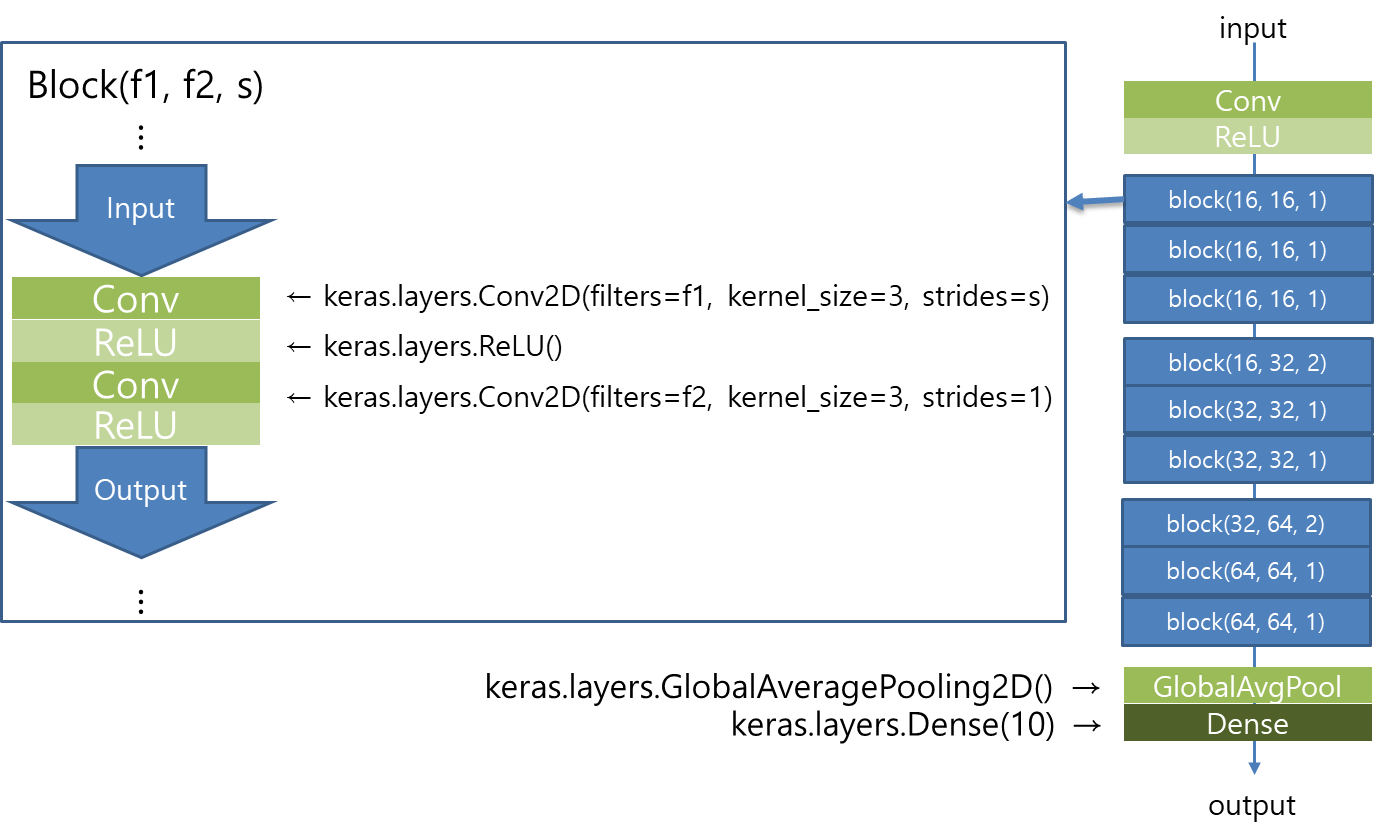

In [18]:
!pip install tensorflow-model-optimization

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

nb_classes = 10
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()
train_x, test_x = train_x / 255.0, test_x / 255.0

train_y = keras.utils.to_categorical(train_y, nb_classes)
test_y = keras.utils.to_categorical(test_y, nb_classes)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


## Without Bacth normalization

In [20]:
class Block(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.layers = keras.Sequential([
      # implement here
      layers.Conv2D(filters=f1, kernel_size=3, strides=s, padding='same', kernel_initializer=kernel_initializer),
      layers.ReLU(),
      layers.Conv2D(filters=f2, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
      layers.ReLU(),
    ])
    """
    padding='same', kernel_initializer 설정 하였는지 확인
    padding='same' 옵션 주지 않으면 feature map 사이즈가 점점 줄어들어 나중엔 input이 1 x 1 이 되어 오류가 납니다.
    """

  def call(self, inputs):
    x = self.layers(inputs)
    return x

class Network(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.ReLU()
    ])

    # implement blocks here
    # use self.block_layers.append()
    self.block_layers = []
    filters_per_stage = [16, 32, 64]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):
        self.block_layers.append(Block(filters, filters, strides))
        strides = 1
    """
    간단하게 작성하기 위하여 for문 사용하였지만 Block을 하나씩 만들어서 block_layers.append()해도 무방
    """

    self.blocks = keras.Sequential(self.block_layers)
    """
    model.summary()에서 구조 확인하기 위하여 keras.Sequential()로 wrapping
    """
    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)

    #implement blocks call here
    x = self.blocks(x)

    x = self.last_layer(x)

    return x

model = Network()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])
"""
Adam optimizer의 Learning rate를 설정할 수 있는데, 0.005로 설정 되어있는 경우 너무 커서 loss가 감소하지 않을 수 있습니다. 0.001로 수정 후 실행하면 학습됩니다.
"""

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

print(model.summary())

Epoch 1/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.1785 - loss: 2.1124 - val_accuracy: 0.3447 - val_loss: 1.6999
Epoch 2/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3524 - loss: 1.6993 - val_accuracy: 0.4185 - val_loss: 1.5671
Epoch 3/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4470 - loss: 1.4869 - val_accuracy: 0.4869 - val_loss: 1.4108
Epoch 4/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5099 - loss: 1.3440 - val_accuracy: 0.5581 - val_loss: 1.2165
Epoch 5/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5773 - loss: 1.1715 - val_accuracy: 0.5954 - val_loss: 1.1349
Epoch 6/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6108 - loss: 1.0860 - val_accuracy: 0.6340 - val_loss: 1.0386
Epoch 7/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6550 - loss: 0.9693 - val_accuracy: 0.6468 - val_loss: 1.0192


Model: "network_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_203 (Sequential)     │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_69 (Block)                │ (None, 32, 32, 16)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_70 (Block)                │ (None, 32, 32, 16)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_71 (Block)                │ (None, 32, 32, 16)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_72 (Block)                │ (None, 16, 16, 32)     │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_73 (Block)                │ (None, 16, 16, 32)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_74 (Block)                │ (None, 16, 16, 32)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_75 (Block)                │ (None, 8, 8, 64)       │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_76 (Block)                │ (None, 8, 8, 64)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_77 (Block)                │ (None, 8, 8, 64)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_213 (Sequential)     │ (None, 8, 8, 64)       │       267,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_214 (Sequential)     │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 807,104 (3.08 MB)

 Trainable params: 269,034 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 538,070 (2.05 MB)

None


## With Batch normalization
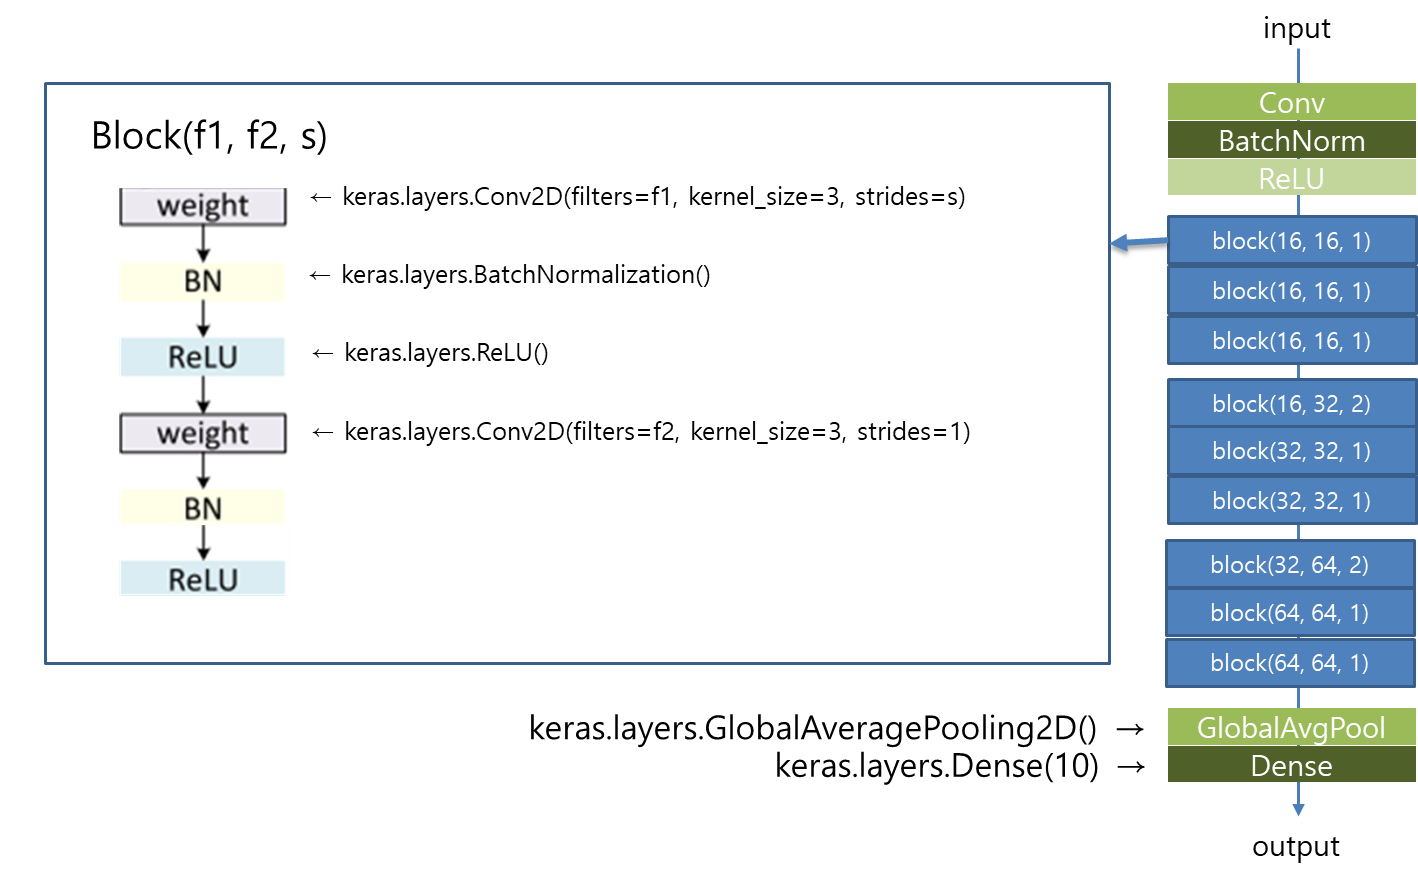

In [21]:
class Block(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.layers = keras.Sequential([
      # implement here
      layers.Conv2D(filters=f1, kernel_size=3, strides=s, padding='same', kernel_initializer=kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(filters=f2, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU(),
    ])

  def call(self, inputs):
    x = self.layers(inputs)
    return x

class Network(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.ReLU()
    ])

    # implement blocks here
    # use self.block_layers.append()
    self.block_layers = []
    filters_per_stage = [16, 32, 64]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):

        self.block_layers.append(Block(filters, filters, strides))
        strides = 1
    self.blocks = keras.Sequential(self.block_layers)

    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)

    #implement blocks call here
    x = self.blocks(x)

    x = self.last_layer(x)

    return x

model = Network()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

print(model.summary())

"""
위의 코드에서 BatchNorm만 추가됨.
성능 비교 하려면 수렴할 정도(더이상 accuracy가 올라가지 않을 정도)로 epoch 늘리고 accuracy 비교해보기
"""

Epoch 1/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.1873 - loss: 2.1015 - val_accuracy: 0.3528 - val_loss: 1.6843
Epoch 2/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3815 - loss: 1.6172 - val_accuracy: 0.4626 - val_loss: 1.4686
Epoch 3/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4779 - loss: 1.4060 - val_accuracy: 0.5170 - val_loss: 1.3160
Epoch 4/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5389 - loss: 1.2652 - val_accuracy: 0.5549 - val_loss: 1.2200
Epoch 5/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5927 - loss: 1.1176 - val_accuracy: 0.5900 - val_loss: 1.1186
Epoch 6/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6296 - loss: 1.0268 - val_accuracy: 0.6234 - val_loss: 1.0728
Epoch 7/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6644 - loss: 0.9400 - val_accuracy: 0.6550 - val_loss: 0.9852


Model: "network_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_215 (Sequential)     │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_78 (Block)                │ (None, 32, 32, 16)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_79 (Block)                │ (None, 32, 32, 16)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_80 (Block)                │ (None, 32, 32, 16)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_81 (Block)                │ (None, 16, 16, 32)     │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_82 (Block)                │ (None, 16, 16, 32)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_83 (Block)                │ (None, 16, 16, 32)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_84 (Block)                │ (None, 8, 8, 64)       │        55,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_85 (Block)                │ (None, 8, 8, 64)       │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_86 (Block)                │ (None, 8, 8, 64)       │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_225 (Sequential)     │ (None, 8, 8, 64)       │       270,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_226 (Sequential)     │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,480 (3.10 MB)

 Trainable params: 270,378 (1.03 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 540,758 (2.06 MB)

None


'\n위의 코드에서 BatchNorm만 추가됨. \n성능 비교 하려면 수렴할 정도(더이상 accuracy가 올라가지 않을 정도)로 epoch 늘리고 accuracy 비교해보기  \n'

##ResNet
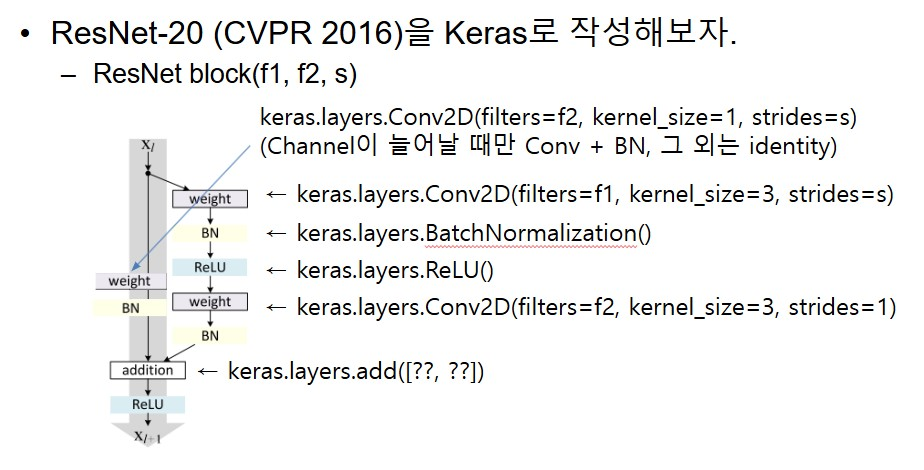

In [22]:
class ResNetBlock(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.residual = keras.Sequential([
      # implement here
      layers.Conv2D(filters=f1, kernel_size=3, strides=s, padding='same', kernel_initializer=kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(filters=f2, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
      layers.BatchNormalization(),
    ])

    # layers.Identity()
    if s == 2:
      self.shortcut = keras.Sequential([
        # implement here
        layers.Conv2D(filters=f2, kernel_size=1, strides=s, kernel_initializer=kernel_initializer, padding='same'),
        layers.BatchNormalization()
      ])
    else:
      self.shortcut = keras.Sequential([
        # implement here
        layers.Identity()
      ])
      """
      채널 수가 변화할 때(stride = 2)만 Conv2D와 BN사용, 나머지는 Identity
      """

  def call(self, inputs):
    # implement here
    # add residual and shortcut
    shortcut = self.shortcut(inputs)

    x = self.residual(inputs)
    x = layers.add([x, shortcut]) # Or, x = x + shortcut
    x = layers.ReLU()(x)

    return x

class ResNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU()
    ])

    # implement blocks here
    # use self.blocks.append()
    self.block_layers = []
    filters_per_stage = [16, 32, 64]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):
        self.block_layers.append(ResNetBlock(filters, filters, strides))
        strides = 1
    self.blocks = keras.Sequential(self.block_layers)

    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)

    #implement blocks call here
    x = self.blocks(x)

    x = self.last_layer(x)

    return x

model = ResNet()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

print(model.summary())


Epoch 1/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.2198 - loss: 2.3238 - val_accuracy: 0.4343 - val_loss: 1.5301
Epoch 2/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.4574 - loss: 1.4717 - val_accuracy: 0.4812 - val_loss: 1.4045
Epoch 3/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5406 - loss: 1.2646 - val_accuracy: 0.5932 - val_loss: 1.1372
Epoch 4/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6126 - loss: 1.0752 - val_accuracy: 0.6275 - val_loss: 1.0236
Epoch 5/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6594 - loss: 0.9511 - val_accuracy: 0.6336 - val_loss: 1.0508
Epoch 6/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6992 - loss: 0.8473 - val_accuracy: 0.6919 - val_loss: 0.8900
Epoch 7/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7294 - loss: 0.7655 - val_accuracy: 0.7091 - val_loss: 0.8179


Model: "res_net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_227 (Sequential)     │ (None, 32, 32, 16)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_27 (ResNetBlock)  │ (None, 32, 32, 16)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_28 (ResNetBlock)  │ (None, 32, 32, 16)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_29 (ResNetBlock)  │ (None, 32, 32, 16)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_30 (ResNetBlock)  │ (None, 16, 16, 32)     │        14,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_31 (ResNetBlock)  │ (None, 16, 16, 32)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_32 (ResNetBlock)  │ (None, 16, 16, 32)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_33 (ResNetBlock)  │ (None, 8, 8, 64)       │        58,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_34 (ResNetBlock)  │ (None, 8, 8, 64)       │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_35 (ResNetBlock)  │ (None, 8, 8, 64)       │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_246 (Sequential)     │ (None, 8, 8, 64)       │       273,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_247 (Sequential)     │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,344 (3.13 MB)

 Trainable params: 273,258 (1.04 MB)

 Non-trainable params: 1,568 (6.12 KB)

 Optimizer params: 546,518 (2.08 MB)

None
